# Determining Sentence Sentiment using NLP

In [ ]:
import torch
import pandas as pd

# My libraries
from src.data_loader import SSTDataPipeline
from src.trainer import Trainer
from src.models import DynamicRNN
from src.plotter import Plotter

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running experiments on hardware type: {DEVICE}")

Experimenting on: cpu


In [ ]:
BATCH_SIZE = 64
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 5  # SST-5
DROPOUT = 0.5
EPOCHS = 15  # Or 15, as per your plan
LEARNING_RATE = 0.001

# Pre-trained Vector Path
VECTOR_PATH = "./data/vector.txt"

In [ ]:
# Initialize Data Pipeline (with vectors)
print("Initializing Data Pipeline...")
data_pipe = SSTDataPipeline(
    vector_path=VECTOR_PATH, batch_size=BATCH_SIZE, device=DEVICE
)
train_iter, val_iter, test_iter = data_pipe.run()

# Get Vocabulary Info
VOCAB_SIZE = data_pipe.vocab_size
PAD_IDX = data_pipe.get_pad_idx()
PRETRAINED_VECTORS = data_pipe.get_embeddings()

print(f"Data ready. Vocab Size: {VOCAB_SIZE}, Pad Index: {PAD_IDX}")

### Part 1: Find the best model

In [ ]:
experiments_config = [
    # --- Naive RNN ---
    {
        "name": "1_RNN_Random",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "2_RNN_Pretrained",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Naive LSTM ---
    {
        "name": "3_LSTM_Random",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "4_LSTM_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Naive GRU ---
    {
        "name": "5_GRU_Random",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "6_GRU_Pretrained",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Better LSTM (Bi-Directional, 2 Layers) ---
    {
        "name": "7_BiLSTM_Deep_Random",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "8_BiLSTM_Deep_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
    # --- Better GRU (Bi-Directional, 2 Layers) ---
    {
        "name": "9_BiGRU_Deep_Random",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "10_BiGRU_Deep_Pretrained",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
]

--> Loading SST splits...
--> Building Vocabulary...
    No vector_path provided. Initializing random embeddings.
    Vocab Size: 16581
--> Creating Iterators...
Starting Vanilla_RNN | Params: 5,118,690
Epoch: 01 | Time: 0m 4s
	Train Loss: 1.658 | Train Acc: 24.00%
	 Val. Loss: 1.586 |  Val. Acc: 26.28%
Epoch: 02 | Time: 0m 4s
	Train Loss: 1.596 | Train Acc: 27.06%
	 Val. Loss: 1.610 |  Val. Acc: 26.98%
Epoch: 03 | Time: 0m 4s
	Train Loss: 1.548 | Train Acc: 31.09%
	 Val. Loss: 1.563 |  Val. Acc: 30.53%
Epoch: 04 | Time: 0m 4s
	Train Loss: 1.513 | Train Acc: 33.33%
	 Val. Loss: 1.541 |  Val. Acc: 32.28%
Epoch: 05 | Time: 0m 5s
	Train Loss: 1.467 | Train Acc: 36.45%
	 Val. Loss: 1.558 |  Val. Acc: 31.32%
Epoch: 06 | Time: 0m 9s
	Train Loss: 1.419 | Train Acc: 38.28%
	 Val. Loss: 1.585 |  Val. Acc: 29.83%
Epoch: 07 | Time: 0m 9s
	Train Loss: 1.370 | Train Acc: 42.16%
	 Val. Loss: 1.542 |  Val. Acc: 35.40%
Epoch: 08 | Time: 0m 10s
	Train Loss: 1.315 | Train Acc: 44.76%
	 Val. Loss: 1.579 

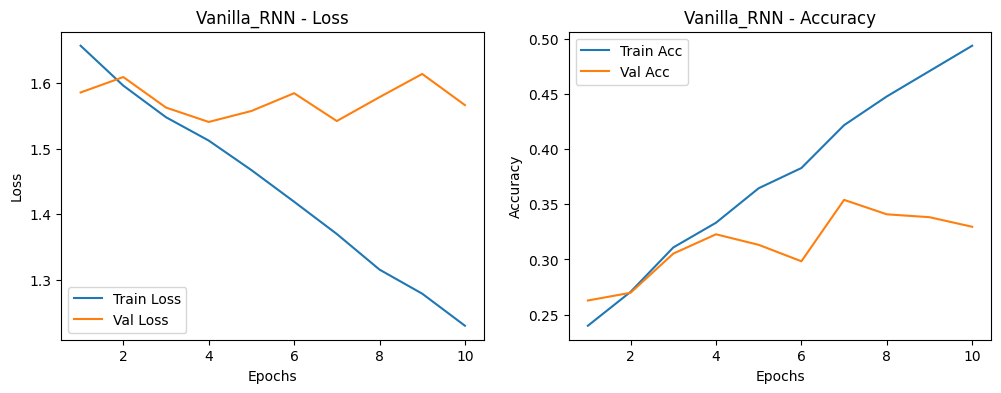

+------------------------------------+-------------+
| Metric                             | Value       |
+------------------------------------+-------------+
| Experiment Name                    | Vanilla_RNN |
| Total Training Time                | 72.55s      |
| Trainable Parameters               | 5,118,690   |
| --- Hyperparameters ---            |             |
| epochs                             | 10          |
| learning_rate                      | 0.001       |
| --- Final Results (Last Epoch) --- |             |
| Final Train Loss                   | 1.2294      |
| Final Train Accuracy               | 49.36%      |
| Final Val Loss                     | 1.5668      |
| Final Val Accuracy                 | 32.96%      |
| Best Val Loss                      | 1.5410      |
| Best Val Accuracy                  | 35.40%      |
| --- Test Results (Best Model) ---  |             |
| Test Loss                          | 1.5217      |
| Test Accuracy                      | 33.42% 

In [ ]:
# Store all results here
all_histories = {}  # Key: Model Name, Value: History Dict
all_summaries = []  # List of Summary Dicts for DataFrame

for config in experiments_config:
    print(f"\n{'='*20} Running: {config['name']} {'='*20}")

    # 1. Init Model
    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=config["bidirectional"],
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        rnn_type=config["rnn_type"],
    )

    # 2. Embeddings
    if config["use_pretrained"]:
        if PRETRAINED_VECTORS is not None:
            print(f"Loading vectors...")
            model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
        else:
            print("Vectors not found, using random.")

    # 3. Hyperparams for record keeping
    hyperparams = {
        "Type": config["rnn_type"].upper(),
        "BiDir": config["bidirectional"],
        "Embeds": "Pretrained" if config["use_pretrained"] else "Random",
        "Layers": config["n_layers"],
    }

    # 4. Train
    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        name=config["name"],
        hyperparameters=hyperparams,
        save_weights=True,
    )

    # 5. Store Data
    all_histories[config["name"]] = history
    all_summaries.append(summary)

print("\nAll models trained successfully.")

In [ ]:
print(f"Generating plots for {len(all_histories)} models...\n")

# You can adjust grid size or plotting logic here
for model_name, history in all_histories.items():
    Plotter.plot_history(history, title=model_name)

In [ ]:
df_results = pd.DataFrame(all_summaries)

# Reorder columns for readability (optional)
cols = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]
# Filter to ensure columns exist before selecting
cols = [c for c in cols if c in df_results.columns]
df_results = df_results[cols + [c for c in df_results.columns if c not in cols]]

# Display
display(df_results.sort_values(by="Best Val Acc", ascending=False))

# Export
csv_path = "sst_experiment_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")